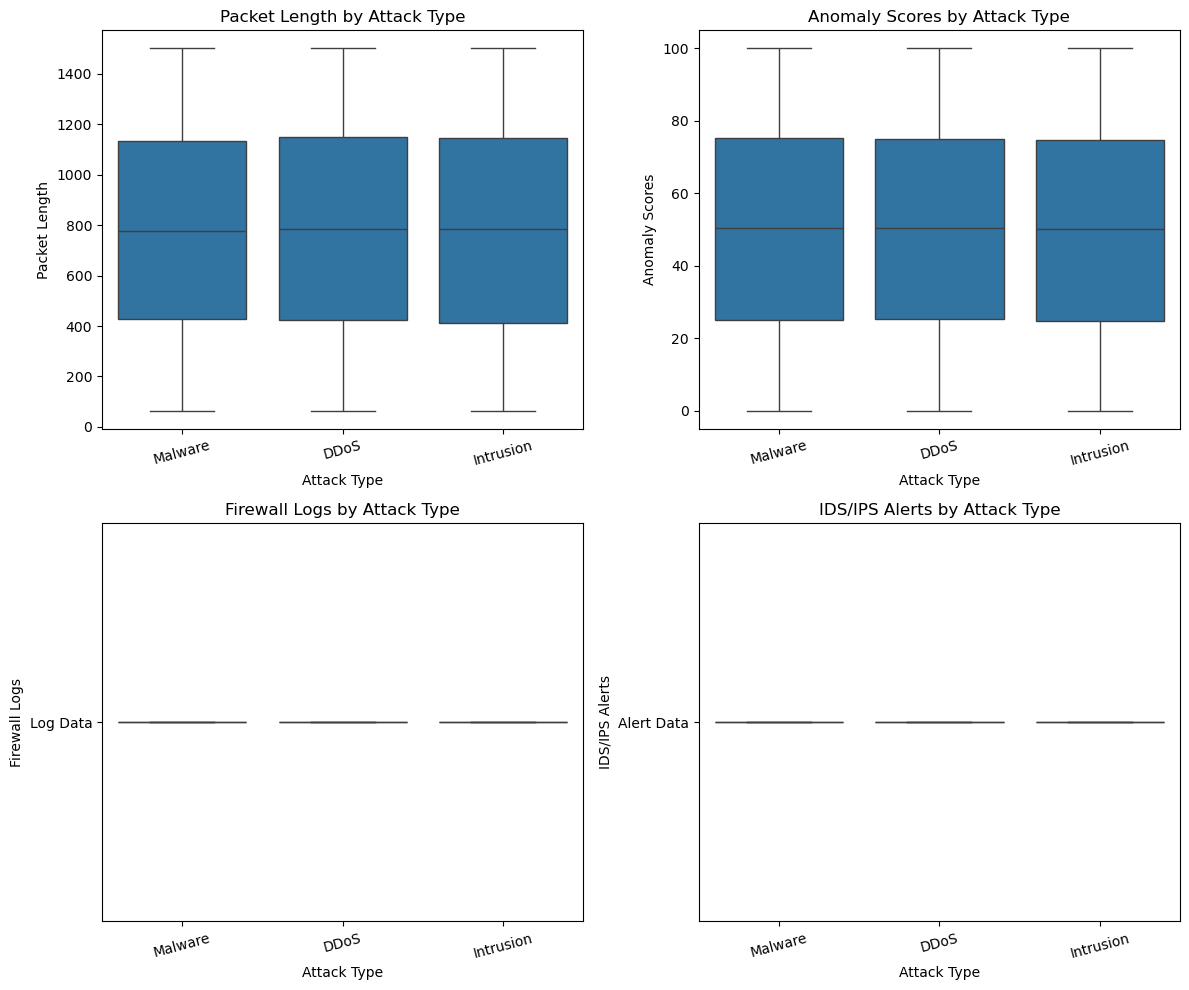

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the original dataset
path = r"C:\Users\2022w\Desktop\Data sci proj\cybersecurity_attacks.csv"
df = pd.read_csv(path)

# Features to compare across attack types
features = ['Packet Length', 'Anomaly Scores', 'Firewall Logs', 'IDS/IPS Alerts']
attack_col = 'Attack Type'

# Plot distribution overlap
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=attack_col, y=feature, data=df)
    plt.title(f"{feature} by {attack_col}")
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [2]:
#Python code to generate the Synthetic Noisy Dataset

import pandas as pd
import numpy as np
import random
import uuid
from datetime import datetime, timedelta

# reproducibility
np.random.seed(21704)
random.seed(21704)

def gen_data(n=40000, noise_pct=0.05):
    recs = []
    types = ["DDoS", "Intrusion", "Malware"]
    pkt_types = ["Control","Data"]
    trf_types = ["HTTP","DNS","FTP","SSH"]

    for i in range(n):
        t = types[i % 3]
        ts = datetime(2023,1,1) + timedelta(seconds=random.randint(0,86400*30))

        if t=="DDoS":
            dur = np.random.uniform(1,80)
            pkts= int(np.random.uniform(1000,3000))
            syn = np.random.uniform(0.1,0.5)
            plen= np.random.normal(200,80)
            ano = np.random.uniform(65,90)
            proto = random.choice(["UDP","ICMP","TCP"])
            trf   = random.choice(trf_types)
            sev   = "High"
            act   = random.choice(["Blocked","Logged"])
        elif t=="Intrusion":
            dur = np.random.uniform(100,250)
            pkts= int(np.random.uniform(500,2200))
            syn = np.random.uniform(0.3,0.7)
            plen= np.random.normal(350,120)
            ano = np.random.uniform(45,75)
            proto = "TCP"
            trf   = random.choice(trf_types)
            sev   = random.choice(["Medium","High"])
            act   = random.choice(["Logged","Blocked"])
        else:  # Malware
            dur = np.random.uniform(300,1800)
            pkts= int(np.random.uniform(150,1800))
            syn = np.random.uniform(0.0,0.4)
            plen= np.random.normal(600,200)
            ano = np.random.uniform(20,60)
            proto = "TCP"
            trf   = random.choice(["HTTP","FTP","DNS"])
            sev   = random.choice(["Low","Medium"])
            act   = random.choice(["Logged","Ignored"])

        pps = pkts / max(dur,1)
        recs.append({
            "id":   str(uuid.uuid4()),
            "ts":   ts,
            "dur":  round(dur,2),
            "pkts": pkts,
            "pps":  round(pps,2),
            "syn":  round(syn,3),
            "plen": round(max(plen,1),2),
            "ano":  round(ano,2),
            "proto": proto,
            "pkt_type": random.choice(pkt_types),
            "trf_type": trf,
            "sev": sev,
            "act": act,
            "label": t
        })

    df = pd.DataFrame(recs)

    # noise: 20% missing in numeric cols
    for c in ["plen","ano","pps","syn"]:
        df.loc[np.random.rand(len(df))<0.20, c] = np.nan

    # 10% duplicates
    df = pd.concat([df, df.sample(frac=0.10, random_state=42)], ignore_index=True)

    # 5% outliers
    for c in ["plen","ano","pps","pkts"]:
        idx = df.sample(frac=0.05, random_state=42).index
        df.loc[idx, c] = df[c].max()*10

    # 5% label flips
    mask = np.random.rand(len(df)) < noise_pct
    df.loc[mask, "label"] = df.loc[mask, "label"].apply(
        lambda x: random.choice([o for o in types if o!=x])
    )

    # shuffle & save
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df.to_csv("synthetic_cyber_attacks_noisy.csv", index=False)
    print("Saved synthetic_cyber_attacks_noisy.csv")

    return df

# generate
df = gen_data()


Saved synthetic_cyber_attacks_noisy.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble       import RandomForestClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.svm            import SVC
from sklearn.metrics        import classification_report, confusion_matrix

# Load
path = r"C:\Users\2022w\Desktop\Data sci proj\synthetic_cyber_attacks_noisy.csv"
df = pd.read_csv(path, parse_dates=["ts"])
print("Raw shape:", df.shape)
df.head()


Raw shape: (44000, 14)


,id,ts,dur,pkts,pps,syn,plen,ano,proto,pkt_type,trf_type,sev,act,label
0,c8e38b5f-aa33-402d-afcf-f08391dd70b6,2023-01-21 04:14:12,10.12,29990,28419.9,0.231,13299.2,900.0,UDP,Data,FTP,High,Blocked,DDoS
1,984a1c2e-9e95-4eb8-bfd8-50916d3efeec,2023-01-13 01:49:27,39.10,29990,28419.9,NaN,13299.2,900.0,UDP,Control,HTTP,High,Blocked,DDoS
2,c1c2d242-5110-4609-8c2c-c6436a6be9dd,2023-01-13 17:11:43,6.25,29990,28419.9,0.496,13299.2,900.0,UDP,Data,HTTP,High,Blocked,DDoS
3,24781d67-0d01-45f9-9817-4658911a48e6,2023-01-28 12:28:34,37.81,29990,28419.9,0.276,13299.2,900.0,UDP,Data,FTP,High,Blocked,DDoS
4,ca0794c4-e59b-48d4-bc2c-7e5fd19e53c3,2023-01-12 12:37:33,1285.17,29990,28419.9,NaN,13299.2,900.0,TCP,Data,DNS,Medium,Logged,Malware


In [4]:
# 1) drop exact duplicates
df = df.drop_duplicates()

# 2) drop rows missing key numerics
df = df.dropna(subset=["plen","ano","pps","syn"])

# 3) clip numeric outliers at 99th percentile
for c in ["plen","ano","pps","pkts"]:
    up = df[c].quantile(0.99)
    df[c] = df[c].clip(upper=up)

# 4) reset index
df = df.reset_index(drop=True)
print("Cleaned shape:", df.shape)


Cleaned shape: (17523, 14)


In [5]:
# missing counts
print(df.isnull().sum())


id          0
ts          0
dur         0
pkts        0
pps         0
syn         0
plen        0
ano         0
proto       0
pkt_type    0
trf_type    0
sev         0
act         0
label       0
dtype: int64


In [6]:
# fill remaining missing numerics with medians
for c in ["dur","pkts","pps","syn","plen","ano"]:
    df[c] = df[c].fillna(df[c].median())

# one‑hot encode small categoricals
df = pd.get_dummies(
    df,
    columns=["proto","pkt_type","trf_type","sev","act"],
    drop_first=True
)

# Separate X/y
X = df.drop(columns=["id","ts","label"])
y = df["label"]

print("Pre‑scale feature shape:", X.shape)

# Scale only numeric columns
num_cols = ["dur","pkts","pps","syn","plen","ano"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("Post‑scale feature shape:", X.shape)


Pre‑scale feature shape: (17523, 16)
Post‑scale feature shape: (17523, 16)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print(y_train.value_counts(), y_test.value_counts())


Train: (14018, 16)  Test: (3505, 16)
label
Malware      4716
Intrusion    4697
DDoS         4605
Name: count, dtype: int64 label
Malware      1180
Intrusion    1174
DDoS         1151
Name: count, dtype: int64


In [8]:
def evaluate(name, model, Xt, yt):
    ypred = model.predict(Xt)
    print(f"--- {name} ---")
    print(classification_report(yt, ypred))
    cm = confusion_matrix(yt, ypred, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=model.classes_,
                yticklabels=model.classes_,
                cbar=False, cmap="mako")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


--- Random Forest ---
              precision    recall  f1-score   support

        DDoS       0.94      0.94      0.94      1151
   Intrusion       0.93      0.93      0.93      1174
     Malware       0.94      0.95      0.94      1180

    accuracy                           0.94      3505
   macro avg       0.94      0.94      0.94      3505
weighted avg       0.94      0.94      0.94      3505



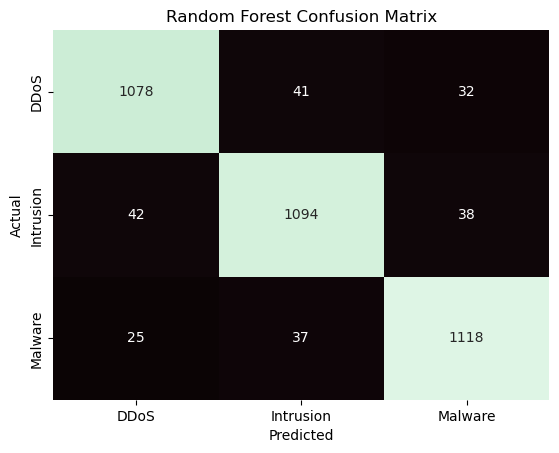

--- Logistic Regression ---
              precision    recall  f1-score   support

        DDoS       0.91      0.90      0.90      1151
   Intrusion       0.89      0.90      0.90      1174
     Malware       0.95      0.94      0.95      1180

    accuracy                           0.91      3505
   macro avg       0.92      0.91      0.91      3505
weighted avg       0.92      0.91      0.92      3505



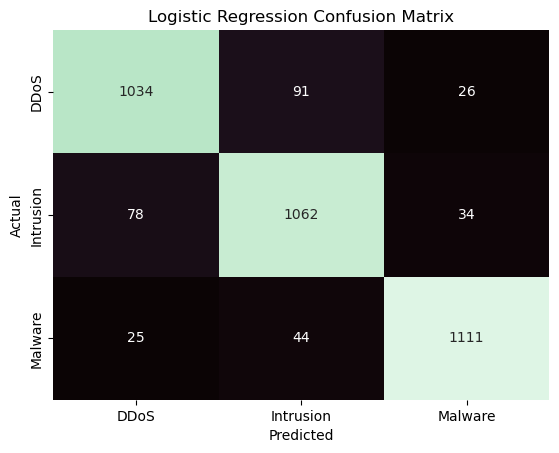

--- SVM (RBF) ---
              precision    recall  f1-score   support

        DDoS       0.94      0.94      0.94      1151
   Intrusion       0.93      0.93      0.93      1174
     Malware       0.95      0.95      0.95      1180

    accuracy                           0.94      3505
   macro avg       0.94      0.94      0.94      3505
weighted avg       0.94      0.94      0.94      3505



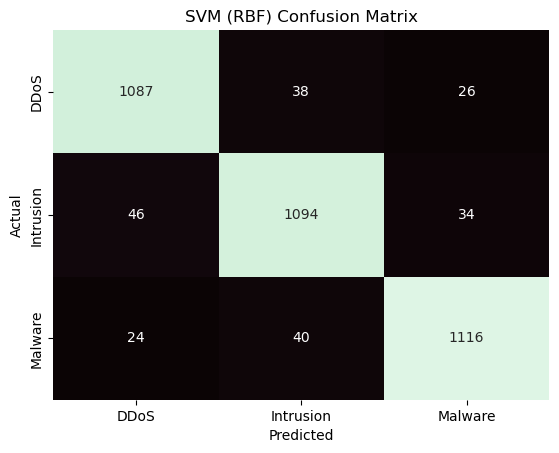

In [9]:
# 7.1 Random Forest
rf = RandomForestClassifier(
    n_estimators=200, class_weight="balanced", random_state=42
)
rf.fit(X_train, y_train)
evaluate("Random Forest", rf, X_test, y_test)

# 7.2 Logistic Regression
lr = LogisticRegression(
    max_iter=2000, class_weight="balanced", random_state=42
)
lr.fit(X_train, y_train)
evaluate("Logistic Regression", lr, X_test, y_test)

# 7.3 SVM (RBF)
svm = SVC(
    kernel="rbf", class_weight="balanced", random_state=42
)
svm.fit(X_train, y_train)
evaluate("SVM (RBF)", svm, X_test, y_test)
